In [ ]:
!pip install stable-baselines==2.9.0

In [ ]:
import datetime
from time import time
from collections import deque

import numpy as np

import torch as T
from torch.autograd import Variable
import torch.nn as nn
from torch.distributions import Categorical
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack, VecNormalize

from tqdm import trange
from google.colab import drive
from itertools import count

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
ENV_NAME = 'BreakoutNoFrameskip-v4'
SAVE_PATH = '/content/gdrive/My Drive/PPO/'

TOTAL_FRAMES = 5e6    # 5 million frames
ROLLOUT_LENGTH = 128  # transitions in each rollout
NENV = 8              # parallel environments; increase to decorrolate batches
GAMMA = 0.99          # reward discounting coefficient
SEED = 420            # blaze it
MB_SPLIT = 4          # split minibatch into quarters for surrogate calculation
MB_EPOCHS = 4         # epochs per minibatch (4 weight updates on policy per mb)
CLIP = 0.2            # clip the surrogate objective so updates are not too big

STEPS_PER_ROLLOUT = ROLLOUT_LENGTH*NENV
TOTAL_UPDATES = int(TOTAL_FRAMES // STEPS_PER_ROLLOUT)
SPLIT_LEN = int(STEPS_PER_ROLLOUT//MB_SPLIT)
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')

set_global_seeds(SEED)

# Neural Net Definitions

In [0]:
def conv_size(net, in_shape):
    """ util for calculating flat output shape of a given net """
    x = Variable(T.rand(1, *in_shape))
    o = net(x)
    b = (-1, o.size(1), o.size(2), o.size(3))
    return b, o.data.view(1, -1).size(1)

In [0]:
class AC(nn.Module):
  
    def __init__(self, input_shape, num_actions):
        super().__init__()
        h, w, c = input_shape

        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, 4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(True),
        )
        
        _, f = conv_size(self.conv, (c,h,w))
        self.backbone = nn.Sequential(self.conv, nn.Flatten())
        self.actor = nn.Linear(f, num_actions)
        self.critic = nn.Linear(f, 1)

    def forward(self, x):
        latent = self.backbone(x)
        return self.actor(latent), self.critic(latent)

# Logging utils

In [0]:
class Logger:

    def __init__(self, print_rate):
        self.log = {'ep_r':[], 'ep_l':[], 'loss':[], 'pgloss':[], 
                    'vloss':[], 'ent':[], 'cf':[]}
        self.n_ep = 0              # total games/episodes
        self.n_update = 1          # total weight updates
        self.n_frames = 0          # env steps (total from checkpoint)
        self.run_frames = 0        # env steps (for this run)
        self.max_rwd = -np.inf     # max rwd out of all games played
        self.start_time = time()   # time we started *this* run
        self.last_checkpoint = 0   # total_frames at last checkpoint
        self.print_rate = print_rate

    def eta(self):  # get hh:mm:ss left to train
        elapsed_time = time() - self.start_time
        frames_left = TOTAL_FRAMES - self.n_frames
        sec_per_frame = elapsed_time / self.n_frames
        sec_left = int(frames_left * sec_per_frame)
        eta_str = str(datetime.timedelta(seconds=sec_left))
        return eta_str

    def fps(self):  # get frames per second
        elapsed_time = time() - self.start_time
        fps = int(self.run_frames / elapsed_time)
        return fps

    def sma(self, x):  # simple moving average
        if len(x) == 0: return 'NaN'
        div = 200 if len(x) > 200 else len(x)
        return sum(list(zip(*x[-div:]))[-1])/div

    def print_log(self):
        fps = self.fps()
        eta = self.eta()
        print('-'*10, self.n_update, '/', TOTAL_UPDATES, '-'*10)
        print('Num Games:', self.n_ep)
        print('Num Frames:', self.n_frames)
        print('FPS:', fps)
        print('ETA:', eta)
        print('SMA Length:', self.sma(self.log['ep_l']))
        print('SMA Reward:', self.sma(self.log['ep_r']))
        print('SMA Entropy:', self.sma(self.log['ent']))
        print('SMA Clip %:', self.sma(self.log['cf']))
        print('SMA Loss:', self.sma(self.log['loss']))
        print('SMA PG Loss:', self.sma(self.log['pgloss']))
        print('SMA V Loss:', self.sma(self.log['vloss']))
        print('Max reward:', self.max_rwd)

    def record(self, ep, loss, pgloss, vloss, ent, cf):
        
        self.n_update += 1
        self.n_frames += STEPS_PER_ROLLOUT
        self.run_frames += STEPS_PER_ROLLOUT
        fr = (self.n_frames, self.n_update)

        # stats about finished episodes/games
        for l, r in zip(ep['l'], ep['r']):
            self.log['ep_l'].append(fr+(l,))
            self.log['ep_r'].append(fr+(r,))
            if r > self.max_rwd: self.max_rwd = r
            self.n_ep += 1
             
        # nn training statistics
        self.log['loss'].append(fr+(loss,))
        self.log['pgloss'].append(fr+(pgloss,))
        self.log['vloss'].append(fr+(vloss,))
        self.log['ent'].append(fr+(ent,))
        self.log['cf'].append(fr+(cf,))
        
        # print log
        if self.n_update % self.print_rate == 0:
            self.print_log()

# Rollout handling

In [0]:
def ob_to_torch(x):
    x = np.moveaxis(x, -1, 1)
    x = T.from_numpy(x).float()
    x = x.to(DEVICE)
    return x

In [0]:
def rollout_generator(env, policy):

    ob = ob_to_torch(env.reset())
    mb = {'obs':[], 'act':[], 'logp':[], 'rwd':[], 'done':[], 'val':[]}
    ep = {'l':[], 'r':[]}  # len & total reward of done eps 
    
    for step in count(1):

        # we compute gradients in the train loop
        with T.no_grad():
            logits, val = policy(ob)
            dist = Categorical(logits=logits)
            action = dist.sample()
            logp = dist.log_prob(action)
        
        new_ob, rwd, done, info = env.step(action)
        
        # store transition
        mb['obs'].append(ob)
        mb['act'].append(action)
        mb['logp'].append(logp)
        mb['rwd'].append(T.from_numpy(rwd))
        mb['val'].append(val.view(-1))
        mb['done'].append(T.from_numpy(done))
        for t in info:
            if t.get('episode'):
                ep['l'].append(t['episode']['l'])
                ep['r'].append(t['episode']['r'])

        ob = ob_to_torch(new_ob)

        if step % ROLLOUT_LENGTH != 0:
            continue

        ########################################################
        ###         Flatten rollout & assign credit          ###
        ########################################################
        ### Credit is bootstrapped from our critic (value    ###
        ### function) if the episode is not terminal. This   ###
        ### bootstrapped credit comes from the estimated     ###
        ### value of the *next* state, making it TD(0).      ###
        ########################################################

        for k in mb.keys():
            mb[k] = T.stack(mb[k]).to(DEVICE)

        # bootstrap from value function - TD(0)
        with T.no_grad():
            last_val = policy(ob)[1].view(-1) * ~mb['done'][-1]
            mb['rwd'][-1] += GAMMA * last_val

        # discount (bootstrapped) rewards
        for i in reversed(range(ROLLOUT_LENGTH-1)):
            mb['rwd'][i] += GAMMA * mb['rwd'][i+1] * ~mb['done'][i]

        # flatten to (NENV*ROLLOUT_LENGTH, ...)
        for k in mb.keys():
            s = mb[k].size()
            mb[k] = mb[k].view(STEPS_PER_ROLLOUT, *s[2:])
        
        yield mb, ep
        mb = {'obs':[], 'act':[], 'logp':[], 'rwd':[], 'done':[], 'val':[]}
        ep = {'l':[], 'r':[]}

# Checkpoint loading and saving

In [0]:
def new_run():
    """ setup parallelised gym environments (MaxAndSkip=4 by default) """
    env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
    env._max_episode_steps = 4500*4
    env = VecFrameStack(env, n_stack=4)
    in_dim = env.observation_space.shape
    policy_dim = env.action_space.n

    # get actor + critic || learning rate is SO important (see README)
    ac = AC(in_dim, policy_dim).to(DEVICE)
    ac_optimizer = Adam(ac.parameters(), 1e-4, eps=1e-5)
    logger = Logger(15)

    return env, ac, ac_optimizer, logger

In [0]:
def save_checkpoint(checkpoint_id):
    checkpoint = {
        'ac': ac.state_dict(),
        'ac_opt': ac_optimizer.state_dict(),
        'logger': logger
    }
    X = str(checkpoint_id)
    T.save(checkpoint, SAVE_PATH+X+'.'+ENV_NAME+'.checkpoint')

In [0]:
def load_checkpoint(file_name):
    checkpoint = T.load(file_name, map_location=DEVICE)

    env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
    env = VecFrameStack(env, n_stack=4)
    in_dim = env.observation_space.shape
    policy_dim = env.action_space.n
    
    ac = AC(in_dim, policy_dim).to(DEVICE)
    ac.load_state_dict(checkpoint['ac'])
    ac_optimizer = Adam(ac.parameters())
    ac_optimizer.load_state_dict(checkpoint['ac_opt'])
    logger = checkpoint['logger']

    return env, ac, ac_optimizer, logger

# Load checkpoint or begin new run

In [0]:
env, ac, ac_optimizer, logger = new_run()
# env, ac, ac_optimizer, logger = load_checkpoint(SAVE_PATH+'3001344.BreakoutNoFrameskip-v4.checkpoint')

rollouts = rollout_generator(env, ac)
lr_scheduler = LambdaLR(ac_optimizer, lambda i: max(0.1, 1 - i/TOTAL_UPDATES))

# Train!

In [14]:
for i_update in range(logger.n_update, TOTAL_UPDATES):

    mb, ep = next(rollouts)
    
    # randomly split mb for surrogate calculation
    ixs = np.arange(STEPS_PER_ROLLOUT)
    
    # multiple updates using each minibatch
    for epoch in range(MB_EPOCHS):
        
        np.random.shuffle(ixs)
        
        for s in range(MB_SPLIT):

            # split minibatch into chunks
            ix = ixs[s*SPLIT_LEN:s*SPLIT_LEN+SPLIT_LEN]
            s_obs = mb['obs'][ix]
            s_logp_old = mb['logp'][ix]
            s_act = mb['act'][ix]
            s_rwd = mb['rwd'][ix]
            s_val_old = mb['val'][ix] 

            # normalized split advantange
            s_adv = s_rwd - s_val_old
            s_adv = (s_adv - s_adv.mean()) / (s_adv.std() + 1e-8)

            # policy gradient + entropy
            logits, val = ac(s_obs)
            dist = Categorical(logits=logits)
            s_ent = dist.entropy().mean()
            s_logp_new = dist.log_prob(s_act)

            # surrogate loss (ratio == 1 on first iter, ln cancels)
            ratio = (s_logp_new - s_logp_old).exp() # e^x / e^x == e^(x-y)
            L_CPI = -s_adv * ratio
            L_CLAMP = -s_adv * ratio.clamp(1-CLIP, 1+CLIP)
            L_CLIP = T.max(L_CPI, L_CLAMP).mean()
            
            # fraction of clipped samples; ensure this is < ~0.15
            # whilst training, else your policy will collapse
            r = ratio.detach()
            clip_frac = ((r < 1-CLIP) | (r > 1+CLIP)).float().mean()
            
            # value loss
            V_L = 0.5 * (val - s_rwd).pow(2).mean()

            # step
            loss = L_CLIP + V_L - 0.01*s_ent
            ac_optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(ac.parameters(), 0.5)
            ac_optimizer.step()

    # decay lr and log training stats
    lr_scheduler.step(i_update)
    logger.record(ep, loss.item(), L_CLIP.item(), V_L.item(),
                  s_ent.item(), clip_frac.item())
    
    # make a checkpoint every 1m frames
    if logger.n_frames - logger.last_checkpoint >= 1e6:
        save_checkpoint(logger.n_frames)
        logger.last_checkpoint = logger.n_frames

---------- 15 / 4882 ----------
Num Games: 73
Num Frames: 14336
FPS: 443
ETA: 3:07:31
SMA Length: 193.04109589041096
SMA Reward: 2.095890410958904
SMA Entropy: 0.7852833185877118
SMA Clip %: 0.30859375
SMA Loss: 0.12252123095095158
SMA PG Loss: 0.006942276111138719
SMA V Loss: 0.12343178982181209
Max reward: 9.0
---------- 30 / 4882 ----------
Num Games: 161
Num Frames: 29696
FPS: 448
ETA: 3:04:47
SMA Length: 194.472049689441
SMA Reward: 2.0869565217391304
SMA Entropy: 0.8472718144285267
SMA Clip %: 0.23733836206896552
SMA Loss: 0.10028513752180955
SMA PG Loss: -0.00042789577153222317
SMA V Loss: 0.10918575178446441
Max reward: 9.0
---------- 45 / 4882 ----------
Num Games: 237
Num Frames: 45056
FPS: 451
ETA: 3:02:47
SMA Length: 202.02
SMA Reward: 2.28
SMA Entropy: 0.8514001030813564
SMA Clip %: 0.18625710227272727
SMA Loss: 0.09492831854996356
SMA PG Loss: -0.003941952610727061
SMA V Loss: 0.10738427217372438
Max reward: 9.0
---------- 60 / 4882 ----------
Num Games: 320
Num Frames: 6

# Save final model and log

In [15]:
save_checkpoint('FINAL')
T.save(logger.log, SAVE_PATH+'FINAL.'+ENV_NAME+'.log')
T.save(ac, SAVE_PATH+'FINAL.'+ENV_NAME+'.MODEL')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Plot results

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

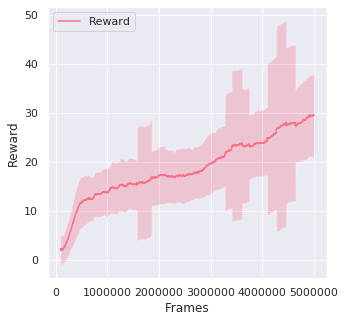

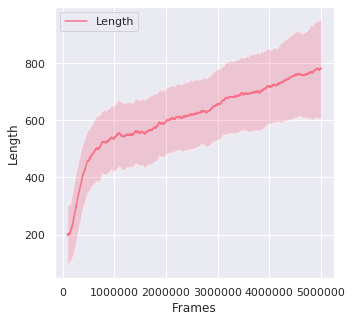

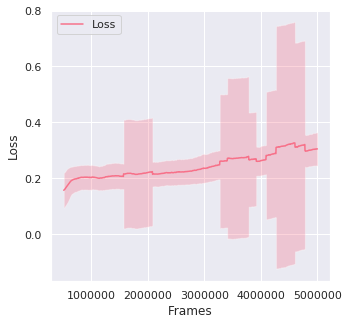

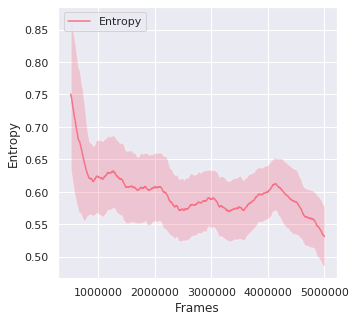

In [17]:
def plot_log(log, ylabel):
    # compute rolling avg and std
    df = pd.DataFrame(log, columns =['Frames', 'Iters', ylabel])
    sma_y = df[ylabel].rolling(500).mean()
    std_y = df[ylabel].rolling(500).std()
    
    # plot with seaborn
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlabel('Frames')
    ax.set_ylabel(ylabel)
    clrs = sns.color_palette("husl", 8)

    # fill standard deviation
    ax.plot(df['Frames'], sma_y, label=ylabel, c=clrs[0])
    ax.fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                    alpha=0.3, facecolor=clrs[0]) 
    ax.legend(loc='upper left')
    plt.savefig(SAVE_PATH+ENV_NAME+'.'+ylabel+'.plt.png', 
                dpi=300, pad_inches=0)
    plt.show()

plot_log(logger.log['ep_r'], 'Reward')
plot_log(logger.log['ep_l'], 'Length')
plot_log(logger.log['loss'], 'Loss')
plot_log(logger.log['ent'], 'Entropy')

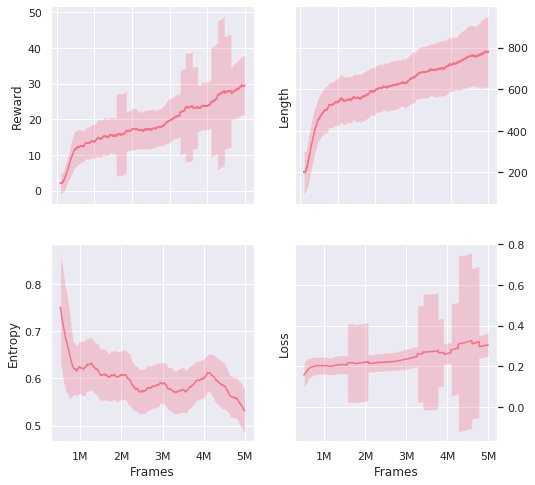

In [18]:
fig_all, ax_all = plt.subplots(2,2, figsize=(8,8))

## REWARD 
df = pd.DataFrame(logger.log['ep_r'], columns =['Frames', 'Iters', 'rwd'])
sma_y = df['rwd'].rolling(500).mean()
std_y = df['rwd'].rolling(500).std()

ax_all[0][0].set_ylabel('Reward')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[0][0].plot(df['Frames'], sma_y, label='Episode Reward', c=clrs[0])
ax_all[0][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
ax_all[0][0].set_xticklabels('')


## LENGTH 
df = pd.DataFrame(logger.log['ep_l'], columns =['Frames', 'Iters', 'Len'])
sma_y = df['Len'].rolling(500).mean()
std_y = df['Len'].rolling(500).std()

ax_all[0][1].set_ylabel('Length')
ax_all[0][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[0][1].plot(df['Frames'], sma_y, label='Episode Length', c=clrs[0])
ax_all[0][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
ax_all[0][1].set_xticklabels('')


## ENTROPY 
df = pd.DataFrame(logger.log['ent'], columns =['Frames', 'Iters', 'ent'])
sma_y = df['ent'].rolling(500).mean()
std_y = df['ent'].rolling(500).std()

ax_all[1][0].set_xlabel('Frames')
ax_all[1][0].set_ylabel('Entropy')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[1][0].plot(df['Frames'], sma_y, label='Entropy', c=clrs[0])
ax_all[1][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[1][0].get_xticks()/1e6]
ax_all[1][0].set_xticklabels(xlabels)


## LOSS 
df = pd.DataFrame(logger.log['loss'], columns =['Frames', 'Iters', 'Loss'])
sma_y = df['Loss'].rolling(500).mean()
std_y = df['Loss'].rolling(500).std()

ax_all[1][1].set_xlabel('Frames')
ax_all[1][1].set_ylabel('Loss')
ax_all[1][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[1][1].plot(df['Frames'], sma_y, label='Loss', c=clrs[0])
ax_all[1][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[1][1].get_xticks()/1e6]
ax_all[1][1].set_xticklabels(xlabels)

plt.savefig(SAVE_PATH+ENV_NAME+'_plot_thesis.png', 
            dpi=300, pad_inches=0, bbox_inches = 'tight')

plt.show()